# < 11. 주식 예측에 도전해 보자 >

## [루브릭]
1. 시계열의 안정성이 충분히 확인되었는가?
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?

## [목차]
1. 시계열 데이터 준비
2. 각종 전처리 수행
3. 시계열 안정성 분석
4. 학습, 테스트 데이터셋 생성
5. 적정 ARIMA 모수 찾기
6. ARIMA 모델 훈련과 테스트
7. 다른 주식 종목 예측해 보기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

---

## STEP 1: 시계열 데이터 준비 - 삼성
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인가능
- 우리는 종가(Close)만 사용 (주식 시장은 정해진 시간 동안만 거래가 가능. 종가란 하루의 장이 마감하였을 때의 가격.)

In [3]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date',parse_dates=True ) 
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


#### <mark>index_col</mark>
- 파일 불러올 때 index_col을 지정해주면 지정한 변수를 index로 만들어준다

In [4]:
# 종가(Close)만 사용
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

---

## STEP2 : 각종 전처리 수행

### 1. 결측치 처리

In [6]:
# 결측치가 있다면 이를 보간
ts = ts.interpolate(method='time')

# 보간 이후 결측치 유무 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

#### <mark>interpolate(method='time')</mark>
- 결측값 보간하는 방법
- 시계열 날짜 index를 기준으로 결측값 보간
- https://rfriend.tistory.com/264

### 2. 로그 변환

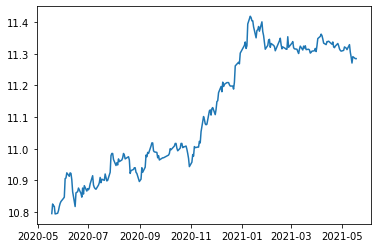

In [7]:
ts_log = np.log(ts)
plt.plot(ts_log)

---

## STEP3 : 시계열 안정성 분석

### 1. 정성적 그래프 분석

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#### <mark>Series.rolling()</mark>
- window : 몇 개씩 연산할지
- .mean() : 평균을 구하라
- https://ordo.tistory.com/67

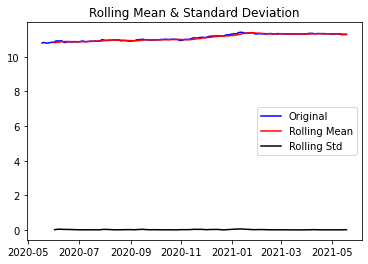

In [9]:
plot_rolling_statistics(ts_log, window=12)

### 2. 정량적 Augmented Dicky-Fuller Test

#### <mark>ADF TEST</mark> 
- 시계열 데이터의 안정성을 테스트하는 통계적 방법
    1. 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,
    2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
    3. 이 시계열 데이터가 안정적이다 라는 대립가설을 채택한다
- p-value의 정의는 귀무가설을 가정했을 때의 확률분포 상에서 현재의 관측보다 더 극단적인 관측이 나올 확률로서, 귀무가설의 가정이 틀렸다고 볼 수 있는 확률이기도 하다. 이 값이 0.05 미만으로 매우 낮게 나온다면 p-value만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거가 된다.

In [10]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#### <mark>adfuller(x, maxlag, regression, autolag)</mark>
- x : 시계열 데이터
- maxlag : p를 지정. 이때 autoloag를 None으로 설정해야 지정한 값이 적용된다
- regression
    - 'c' : 디폴트. 추세는 없고 상수항이 존재한다고 가정
    - 'nc' : 상수항과 추세가 없다고 가정
    - 'ct' : 추세와 상수항이 둘다 존재한다고 가정
    - 'ctt' : 상수항과 일차, 이차 추세가 모두 존재한다고 가정
- autolag : p를 자동으로 지정
    - 'AIC', 'BIC' : AIC나 BIC가 가장 낮게 나오는 p를 자동으로 설정하고 autolag를 이렇게 지정하였을 경우 maxlag에서 지정한 값이 무시된다
    - None : maxlag에서 지정한 값이 설정
- https://hongl.tistory.com/98

In [11]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- p-value가 0.5로 0.05이상으로 stationary하지 않은 데이터!

### 3. 시계열 분해(Time Series Decomposition)
-  statsmodels 라이브러리 안에는 <code>seasonal_decompose</code> 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있다

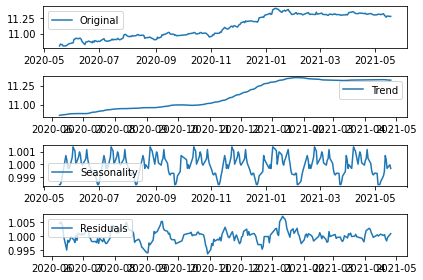

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 4. Residual 안정성 확인

In [13]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


---

## STEP4: 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

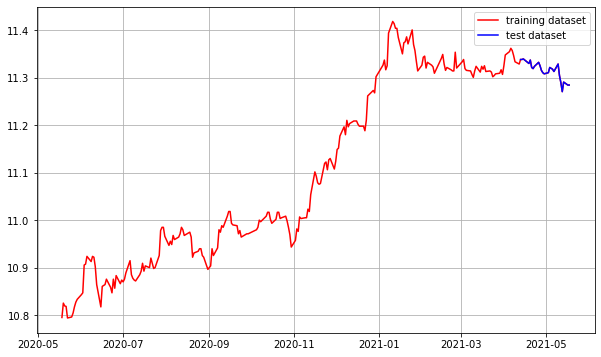

In [14]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

---

## STEP5: 적정 ARIMA 모수 찾기

### ARIMA
- `AR`은 시계열의 `Residual`에 해당하는 부분을 모델링한다고 볼 수 있다
- `MA`는 시계열의 `Trend`에 해당하는 부분을 모델링한다고 볼 수 있다
- `I`는 시계열의 `Seasonality`에 해당하는 부분을 모델링한다고 볼 수 있다

### ARIMA 모델의 모수 p,q,d
- ARIMA의 모수는 아래의 3가지가 있다
    - p : 자기회귀 모형(AR)의 시차
    - d : 차분 누적(I) 횟수
    - q : 이동평균 모형(MA)의 시차

### 1. ACF, PACF 그려보기 -> p,q 구하기
- <mark>ACF</mark>
    - 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
    - ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄
    - 시계열의 현재 값이 과거값과 어떻게 상관되는지 설명
- <mark>PACF</mark>
    - 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수    

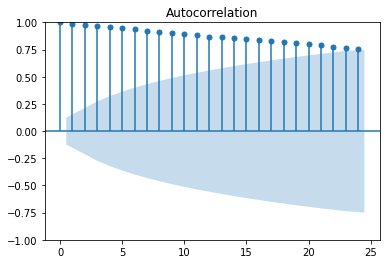

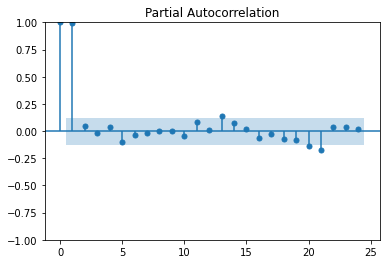

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- PACF 그래프를 보면 p=2 이상인 구간에서는 0에 가까워지고 있기 때문에 p=1이 적합하다
- ACF는 점차 감소하고 있는걸 보면 AR(1) 모델에 유사한 형태를 보이고 있다

### 2. 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


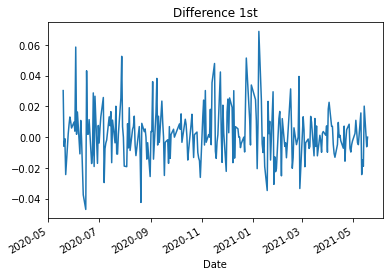

In [18]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


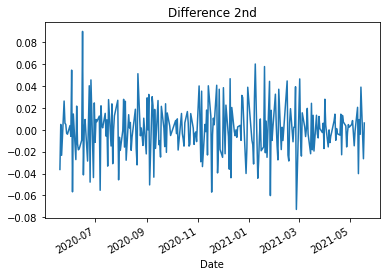

In [17]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

---

## STEP6: ARIMA 모델 훈련과 테스트

### 1. ARIMA 모델 빌드와 훈련
- 위의 PACF 그래프를 통해 P = 1, q = 0 
- 1차 차분 결과를 보면 시계열이 안정된 상태임을 알 수 있다. 그래서 d = 1

In [20]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Wed, 16 Feb 2022   AIC                          -1162.976
Time:                        14:36:22   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

### 2. 모델 테스트 및 플로팅

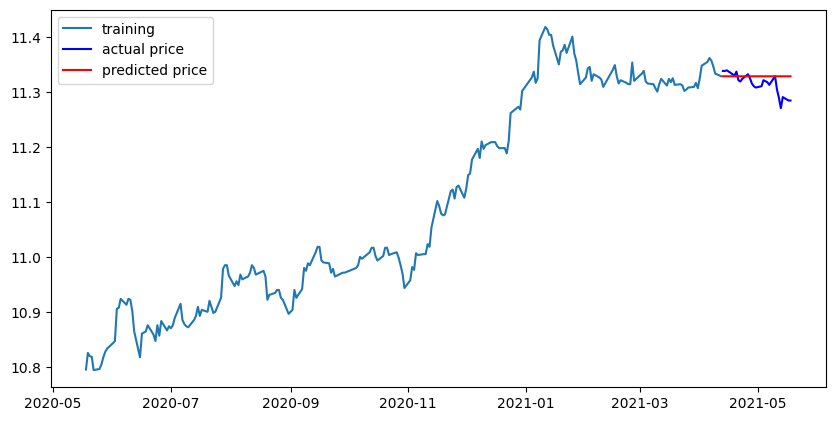

In [21]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

- predicted price를 보면 actual price와 앞에서는 비슷하지만 뒤에서는 차이가 나는걸 볼 수 있다

### 3. 최종 예측 모델 정확도 측정(MAPE)

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


> 1년치 주가에 대한 예측은 1.74%의 낮은 오차율을 보여줌

---
---

## 네이버

## STEP 1: 시계열 데이터 준비

In [23]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/035420.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date',parse_dates=True ) 
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-17,396500.0,396500.0,386000.0,392000.0,391489.21875,1161595
2021-02-18,391500.0,400000.0,386500.0,388000.0,387494.43750,1020222
2021-02-19,387000.0,398500.0,385500.0,398000.0,397481.40625,1047043
2021-02-22,400000.0,405500.0,384500.0,386500.0,385996.37500,1289395
2021-02-23,379000.0,394500.0,378500.0,390500.0,389991.15625,1017577


In [24]:
# 종가(Close)만 사용
ts = df['Close']

ts.head()

Date
2021-02-17    392000.0
2021-02-18    388000.0
2021-02-19    398000.0
2021-02-22    386500.0
2021-02-23    390500.0
Name: Close, dtype: float64

---

## STEP2 : 각종 전처리 수행

### 1. 결측치 처리

In [25]:
# 결측치가 있다면 이를 보간
ts = ts.interpolate(method='time')

# 보간 이후 결측치 유무 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

### 2. 로그 변환

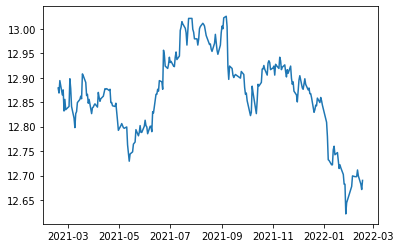

In [26]:
ts_log = np.log(ts)
plt.plot(ts_log)

---

## STEP3 : 시계열 안정성 분석

### 1. 정성적 그래프 분석

In [27]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

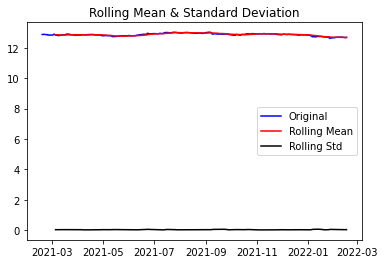

In [28]:
plot_rolling_statistics(ts_log, window=12)

### 2. 정량적 Augmented Dicky-Fuller Test

In [29]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.979421
p-value                          0.760696
#Lags Used                       2.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


- p-value가 0.5로 0.05이상으로 stationary하지 않은 데이터!

### 3. 시계열 분해(Time Series Decomposition)

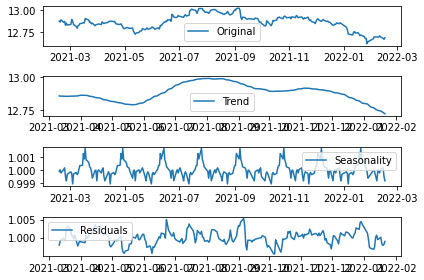

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 4. Residual 안정성 확인

In [31]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.161493e+00
p-value                        7.155922e-08
#Lags Used                     1.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


---

## STEP4: 학습, 테스트 데이터셋 생성

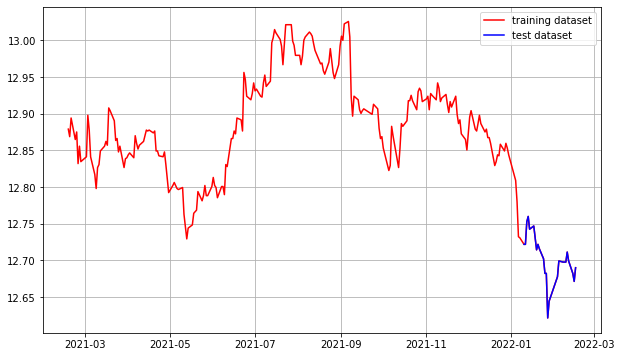

In [32]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

---

## STEP5: 적정 ARIMA 모수 찾기

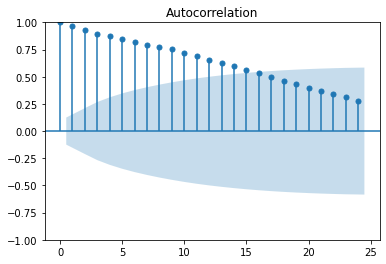

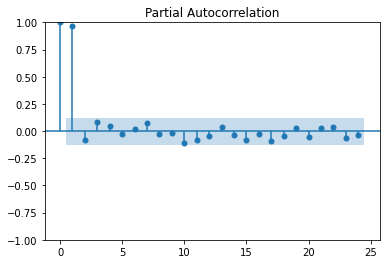

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- PACF 그래프를 보면 p=2 이상인 구간에서는 0에 가까워지고 있기 때문에 p=1이 적합하다
- ACF는 점차 감소하고 있는걸 보면 AR(1) 모델에 유사한 형태를 보이고 있다

### 2. 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.199495e+01
p-value                        3.451273e-22
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


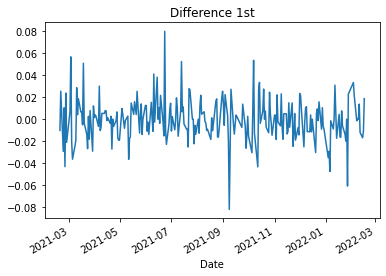

In [34]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

---

## STEP6: ARIMA 모델 훈련과 테스트

### 1. ARIMA 모델 빌드와 훈련
- 위의 PACF 그래프를 통해 P = 1, q = 0 
- 1차 차분 결과를 보면 시계열이 안정된 상태임을 알 수 있다. 그래서 d = 1

In [35]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 562.418
Date:                Wed, 16 Feb 2022   AIC                          -1120.836
Time:                        15:10:35   BIC                          -1114.039
Sample:                             0   HQIC                         -1118.092
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0305      0.069      0.442      0.659      -0.105       0.166
sigma2         0.0004   2.29e-05     15.767      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

### 2. 모델 테스트 및 플로팅

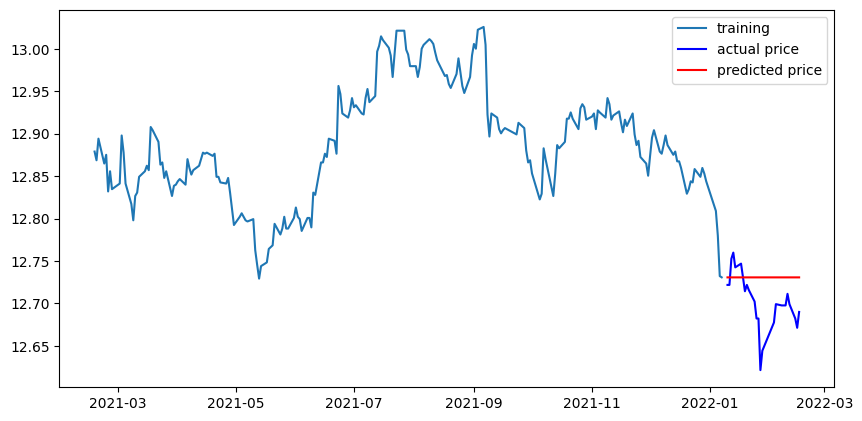

In [36]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 3. 최종 예측 모델 정확도 측정(MAPE)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  185578930.44514742
MAE:  11110.596706969149
RMSE:  13622.735791504856
MAPE: 3.45%


> 플로팅에서 보면 차이가 좀 나서 처음한 삼성 주가 예측보다는 정확도가 높게 나올 것 같았는데 MAPE를 보면 3.45%로 예상이 맞았다 

---
---

## Kakao

## STEP 1: 시계열 데이터 준비

In [38]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/035720.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date',parse_dates=True ) 
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-17,103000.0,103000.0,100600.0,101800.0,101752.468750,2812860
2021-02-18,101200.0,103400.0,100200.0,100200.0,100153.210938,2334610
2021-02-19,99400.0,101200.0,98000.0,100800.0,100752.929688,3478320
2021-02-22,101000.0,102000.0,98000.0,98100.0,98054.195313,3204965
2021-02-23,96300.0,98500.0,95400.0,97400.0,97354.523438,3327085


In [39]:
# 종가(Close)만 사용
ts = df['Close']

ts.head()

Date
2021-02-17    101800.0
2021-02-18    100200.0
2021-02-19    100800.0
2021-02-22     98100.0
2021-02-23     97400.0
Name: Close, dtype: float64

---

## STEP2 : 각종 전처리 수행

### 1. 결측치 처리

In [40]:
# 결측치가 있다면 이를 보간
ts = ts.interpolate(method='time')

# 보간 이후 결측치 유무 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

### 2. 로그 변환

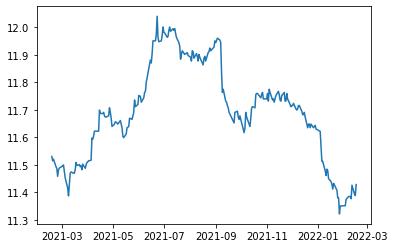

In [41]:
ts_log = np.log(ts)
plt.plot(ts_log)

---

## STEP3 : 시계열 안정성 분석

### 1. 정성적 그래프 분석

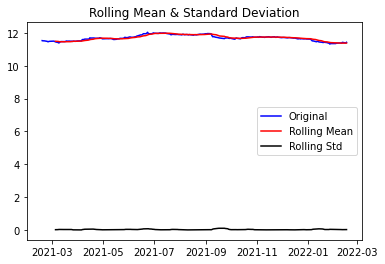

In [42]:
plot_rolling_statistics(ts_log, window=12)

### 2. 정량적 Augmented Dicky-Fuller Test

In [43]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.567362
p-value                          0.499965
#Lags Used                       7.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


### 3. 시계열 분해(Time Series Decomposition)

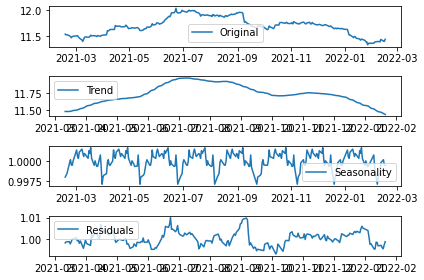

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 4. Residual 안정성 확인

In [45]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.259879
p-value                          0.000521
#Lags Used                       3.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


---

## STEP4: 학습, 테스트 데이터셋 생성

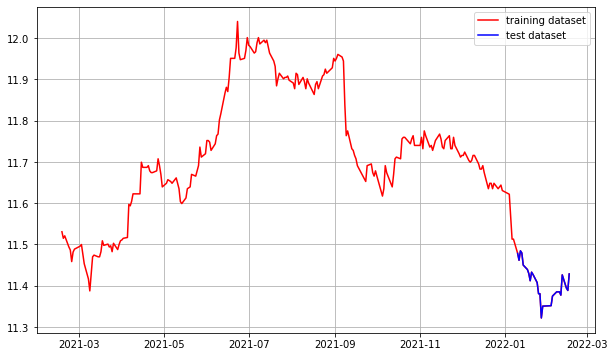

In [48]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

---

## STEP5: 적정 ARIMA 모수 찾기

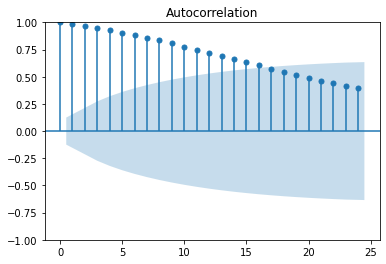

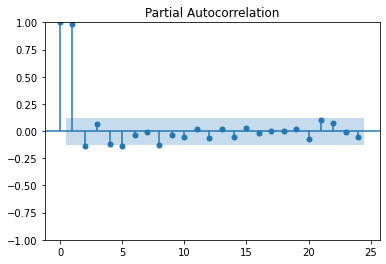

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 2. 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -7.877869e+00
p-value                        4.789892e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


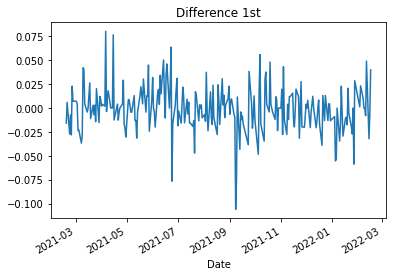

In [50]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

---

## STEP6: ARIMA 모델 훈련과 테스트

### 1. ARIMA 모델 빌드와 훈련
- 위의 PACF 그래프를 통해 P = 1, q = 0 
- 1차 차분 결과를 보면 시계열이 안정된 상태임을 알 수 있다. 그래서 d = 1

In [52]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 515.320
Date:                Wed, 16 Feb 2022   AIC                          -1026.639
Time:                        15:20:45   BIC                          -1019.843
Sample:                             0   HQIC                         -1023.895
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0855      0.050      1.726      0.084      -0.012       0.183
sigma2         0.0006   3.46e-05     15.950      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

### 2. 모델 테스트 및 플로팅

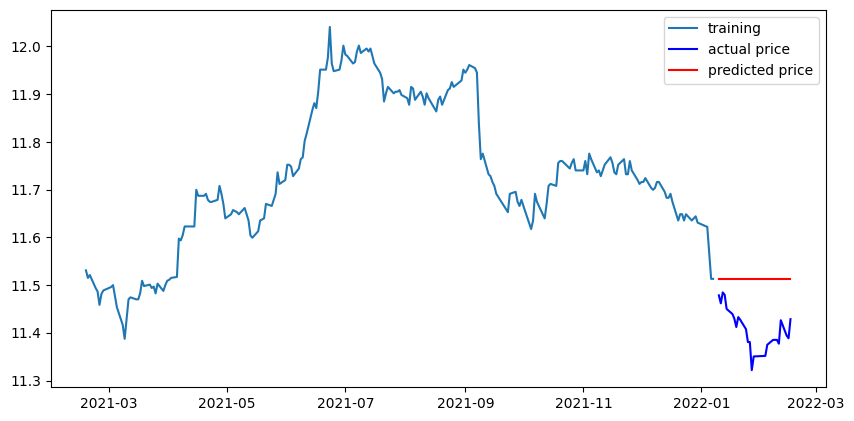

In [53]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 3. 최종 예측 모델 정확도 측정(MAPE)

In [54]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  109576800.00000048
MAE:  9768.000000000024
RMSE:  10467.893770955096
MAPE: 11.02%


> 그래프를 보면 predicted price와 actual price가 위에서 나온 것과는 다르게 많이 차이가 나는걸 볼 수 있는데 역시나 MAPE를 확인해보니 11.02%로 앞서한 두개보다는 많이 높게 나왔다

### 4. 2차 차분을 이용하면?

In [55]:
model = ARIMA(train_data, order=(1, 2, 0)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  222
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 465.813
Date:                Wed, 16 Feb 2022   AIC                           -927.625
Time:                        15:23:44   BIC                           -920.838
Sample:                             0   HQIC                          -924.884
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4147      0.060     -6.905      0.000      -0.532      -0.297
sigma2         0.0008    5.9e-05     14.363      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   7.54   Jarque-

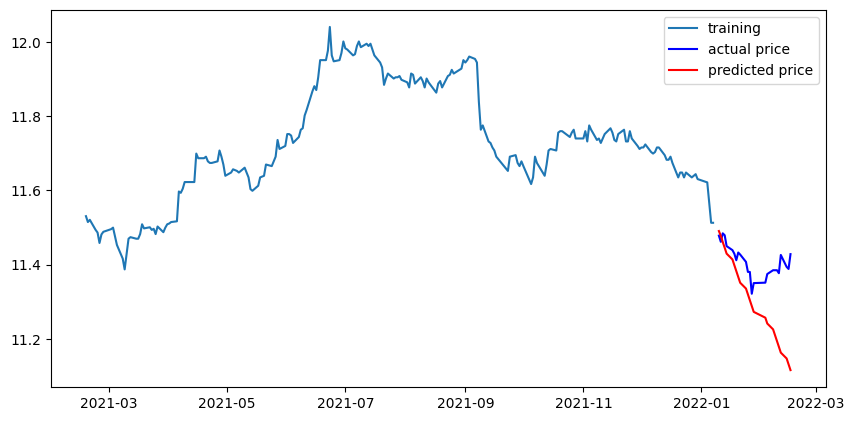

In [56]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [57]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  125474535.09329729
MAE:  8766.563217450654
RMSE:  11201.541639135985
MAPE: 9.82%


> 2차 차분을 했을 때 1차 차분했을 때보다 MAPE가 낮게 나왔다. <br>
하지만 모델을 보면 Log Likelihood가 1차 차분이 더 높다

---

## 회고
- 주식을 잘 몰라서 막 흥미롭지는 않았지만 자격증 공부할 때 배우던 시계열 데이터 분석을 직접 실습하니까 완전히 잘 알게 된 것 같다. 이번 익스는 쉬어가는 느낌이었던 것 같다. 주식을 예측할 수 있다면 세상엔 부자가 넘쳐났겠지..? 